# Setup

In [42]:
import pandas
import psycopg2 as sql
from psycopg2 import extensions as ext

In [43]:
import graph_tool.all as gt
import numpy.random
from pylab import *
np.random.seed(43)
gt.seed_rng(42)

In [44]:
homedir = %env HOME
%reload_ext sql
%config SqlMagic.short_errors=False
%config SqlMagic.dsn_filename='{homedir}/.odbc.ini'
%config SqlMagic.autopandas=True

In [45]:
%%sql [local_graph]
SELECT version()

1 rows affected.


,version
0,PostgreSQL 9.4.24 (Greenplum Database 6.7.1+de...


In [46]:
%sql SELECT madlib.version()

 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.


,version
0,"MADlib version: 1.18.0-dev, git revision: rel/..."


# Single Small Rideshare Problem  (5 verticies, 11 edges)

In [47]:
%sql SELECT * FROM rideshare_v ORDER BY vertex

 * postgresql://dominovaldano@localhost:6000/graph
5 rows affected.


,vertex
0,0
1,1
2,2
3,3
4,4


In [48]:
edges = %sql SELECT * FROM rideshare_e ORDER BY src, dest
edges

 * postgresql://dominovaldano@localhost:6000/graph
9 rows affected.


,src,dest,weight
0,0,1,4.0
1,0,2,2.0
2,1,2,3.0
3,1,3,2.0
4,1,4,3.0
5,2,1,1.0
6,2,3,4.0
7,2,4,5.0
8,4,3,1.0


In [49]:
rideshare_9edges = gt.Graph()
eweight = rideshare_9edges.new_ep("int")
rideshare_9edges.add_edge_list(edges.values, eprops=[eweight])
rideshare_9edges

<Graph object, directed, with 5 vertices and 9 edges, at 0x1558c49a0>

In [50]:
vertices = rideshare_9edges.get_vertices()

In [51]:
node_ids = rideshare_9edges.new_vertex_property("int")

In [52]:
for v in rideshare_9edges.get_vertices():
    node_ids[v] = v

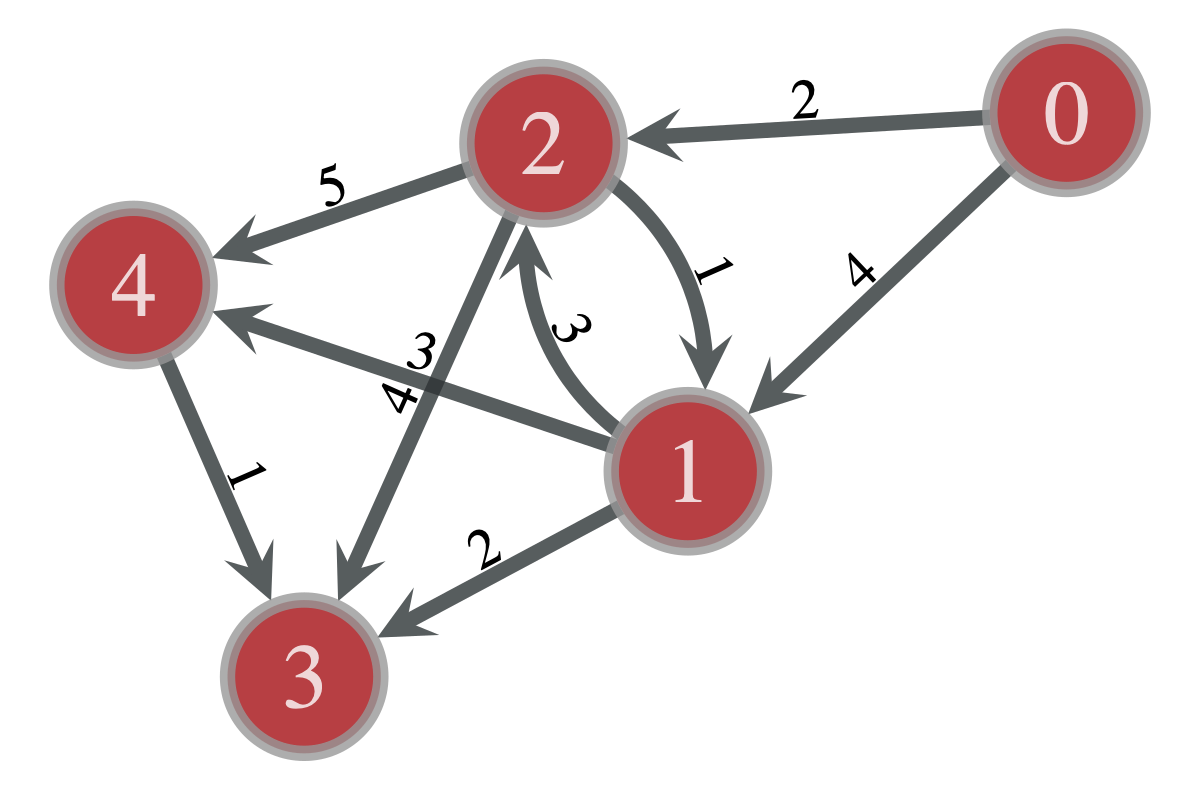

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1558c49a0, at 0x155885670>

In [53]:
edge_properties = {'text' : eweight, 'marker_size' : 28, 'text_out_width' : 0.5, 'font_size' : 28 }
gt.graph_draw(rideshare_9edges, eprops=edge_properties, vertex_text=node_ids)

In [54]:
%config SqlMagic.autopandas=False
%sql SELECT madlib.graph_sssp('usage')

 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.


graph_sssp
"Given a graph and a source vertex, single source shortest path (SSSP)algorithm finds a path for every vertex such that the sum of theweights of its constituent edges is minimized. ---------------------------------------------------------------------------- USAGE ---------------------------------------------------------------------------- SELECT madlib.graph_sssp( vertex_table TEXT, -- Name of the table that contains the vertex data. vertex_id TEXT, -- Name of the column containing the vertex ids. edge_table TEXT, -- Name of the table that contains the edge data. edge_args TEXT, -- A comma-delimited string containing multiple -- named arguments of the form ""name=value"". source_vertex INT, -- The source vertex id for the algorithm to start. out_table TEXT, -- Name of the table to store the result of SSSP. grouping_cols TEXT -- The list of grouping columns. ); The following parameters are supported for edge table arguments ('edge_args' above): src (default = 'src'): Name of the column containing the source vertex ids in the edge table. dest (default = 'dest'): Name of the column containing the destination vertex ids in the edge table. weight (default = 'weight'): Name of the column containing the weight of edges in the edge table. To retrieve the path for a specific vertex: SELECT madlib.graph_sssp_get_path( sssp_table TEXT, -- Name of the table that contains the SSSP output. dest_vertex INT, -- The vertex that will be the destination of the -- desired path. path_table TEXT -- Name of the output table that contains the path.);---------------------------------------------------------------------------- OUTPUT----------------------------------------------------------------------------The output of SSSP ('out_table' above) contains a row for every vertex ofevery group and have the following columns (in addition to the groupingcolumns): - vertex_id : The id for the destination. Will use the input parameter 'vertex_id' for column naming. - weight : The total weight of the shortest path from the source vertex to this particular vertex. Will use the input parameter 'weight' for column naming. - parent : The parent of this vertex in the shortest path from source. Will use 'parent' for column naming.The output of graph_sssp_get_path ('path_table' above) contains a row forevery group and has the following columns: - grouping_cols : The grouping columns given in the creation of the SSSP table. If there are no grouping columns, these columns will not exist and the table will have a single row. - path (ARRAY) : The shortest path from the source vertex (as specified in the SSSP execution) to the destination vertex."


In [55]:
%config SqlMagic.autopandas=True

In [56]:
%sql DROP TABLE IF EXISTS rideshare_shortest_path, rideshare_shortest_path_summary
%time %sql SELECT madlib.graph_sssp('rideshare_v', 'vertex', 'rideshare_e', NULL, 0, 'rideshare_shortest_path');

 * postgresql://dominovaldano@localhost:6000/graph
Done.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
CPU times: user 4.48 ms, sys: 668 µs, total: 5.15 ms
Wall time: 2.63 s


,graph_sssp
0,


In [57]:
df = %sql SELECT vertex,parent,weight FROM rideshare_shortest_path ORDER BY weight
df.index = df.vertex
df.drop(columns='vertex')

 * postgresql://dominovaldano@localhost:6000/graph
5 rows affected.


,parent,weight
vertex,,
0,0,0.0
2,0,2.0
1,2,3.0
3,1,5.0
4,1,6.0


In [58]:
vertices = list(df.index)
parents = { v : p for v,p in zip(vertices,df['parent']) }
weights = { v : w for v,w in zip(vertices,df['weight']) }

In [59]:
%sql DROP TABLE IF EXISTS rideshare_path3
%time %sql SELECT madlib.graph_sssp_get_path('rideshare_shortest_path',3,'rideshare_path3');
%sql SELECT * FROM rideshare_path3;

 * postgresql://dominovaldano@localhost:6000/graph
Done.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
CPU times: user 3.55 ms, sys: 490 µs, total: 4.04 ms
Wall time: 1.33 s
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.


,path
0,"[0, 2, 1, 3]"


# 150 Small Rideshare Problems in Parallel

In [60]:
%sql SELECT * FROM rideshare150_e

 * postgresql://dominovaldano@localhost:6000/graph
1350 rows affected.


,driver_id,driver,src,dest,weight
0,2,Alice_J,1,3,2.0
1,7,Melanie_J,1,3,2.0
2,19,Dave_J,1,3,2.0
3,34,Kate_P,1,3,2.0
4,41,Chang_P,1,3,2.0
...,...,...,...,...,...
1345,120,Fred_M,1,4,3.0
1346,138,Veronica_M,1,4,3.0
1347,141,Alice_M,1,4,3.0
1348,144,Zhung_M,1,4,3.0


In [61]:
%%sql
DROP TABLE IF EXISTS rideshare150_out, rideshare150_out_summary;
SELECT madlib.graph_sssp('rideshare_v', 'vertex', 'rideshare150_e', NULL, 0, 'rideshare150_out', 'driver');

 * postgresql://dominovaldano@localhost:6000/graph
Done.
1 rows affected.


,graph_sssp
0,


In [63]:
%sql SELECT * FROM rideshare150_out ORDER BY driver, weight

 * postgresql://dominovaldano@localhost:6000/graph
750 rows affected.


,driver,vertex,weight,parent
0,Alice_A,0,0.0,0
1,Alice_A,2,2.0,0
2,Alice_A,1,3.0,2
3,Alice_A,3,5.0,1
4,Alice_A,4,6.0,1
...,...,...,...,...
745,Zhung_P,0,0.0,0
746,Zhung_P,2,2.0,0
747,Zhung_P,1,3.0,2
748,Zhung_P,3,5.0,1


In [64]:
%sql DROP TABLE IF EXISTS rideshare150_path3;
%time %sql SELECT madlib.graph_sssp_get_path('rideshare150_out',3,'rideshare150_path3');
%sql SELECT * FROM rideshare150_path3 ORDER BY driver;

 * postgresql://dominovaldano@localhost:6000/graph
Done.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
CPU times: user 4.65 ms, sys: 555 µs, total: 5.2 ms
Wall time: 1.48 s
 * postgresql://dominovaldano@localhost:6000/graph
150 rows affected.


,driver,path
0,Alice_A,"[0, 2, 1, 3]"
1,Alice_J,"[0, 2, 1, 3]"
2,Alice_M,"[0, 2, 1, 3]"
3,Alice_N,"[0, 2, 1, 3]"
4,Alice_P,"[0, 2, 1, 3]"
...,...,...
145,Zhung_A,"[0, 2, 1, 3]"
146,Zhung_J,"[0, 2, 1, 3]"
147,Zhung_M,"[0, 2, 1, 3]"
148,Zhung_N,"[0, 2, 1, 3]"


# Big Graph ( 2000 Vertices / 10000+ Edges )

In [65]:
edges = %sql SELECT * FROM graph_10000edges_e ORDER BY src, dest
edges

 * postgresql://dominovaldano@localhost:6000/graph
9919 rows affected.


,id,src,dest,weight
0,7,0,369,7
1,2,0,389,10
2,6,0,587,7
3,4,0,646,6
4,3,0,789,2
...,...,...,...,...
9914,9918,1999,212,7
9915,9917,1999,260,5
9916,9919,1999,482,2
9917,9916,1999,1053,9


In [66]:
graph_10000edges = gt.Graph()
eweight = graph_10000edges.new_ep("string")
graph_10000edges.add_edge_list(edges.values, eprops=[eweight])
graph_10000edges

<Graph object, directed, with 9920 vertices and 9919 edges, at 0x155de7970>

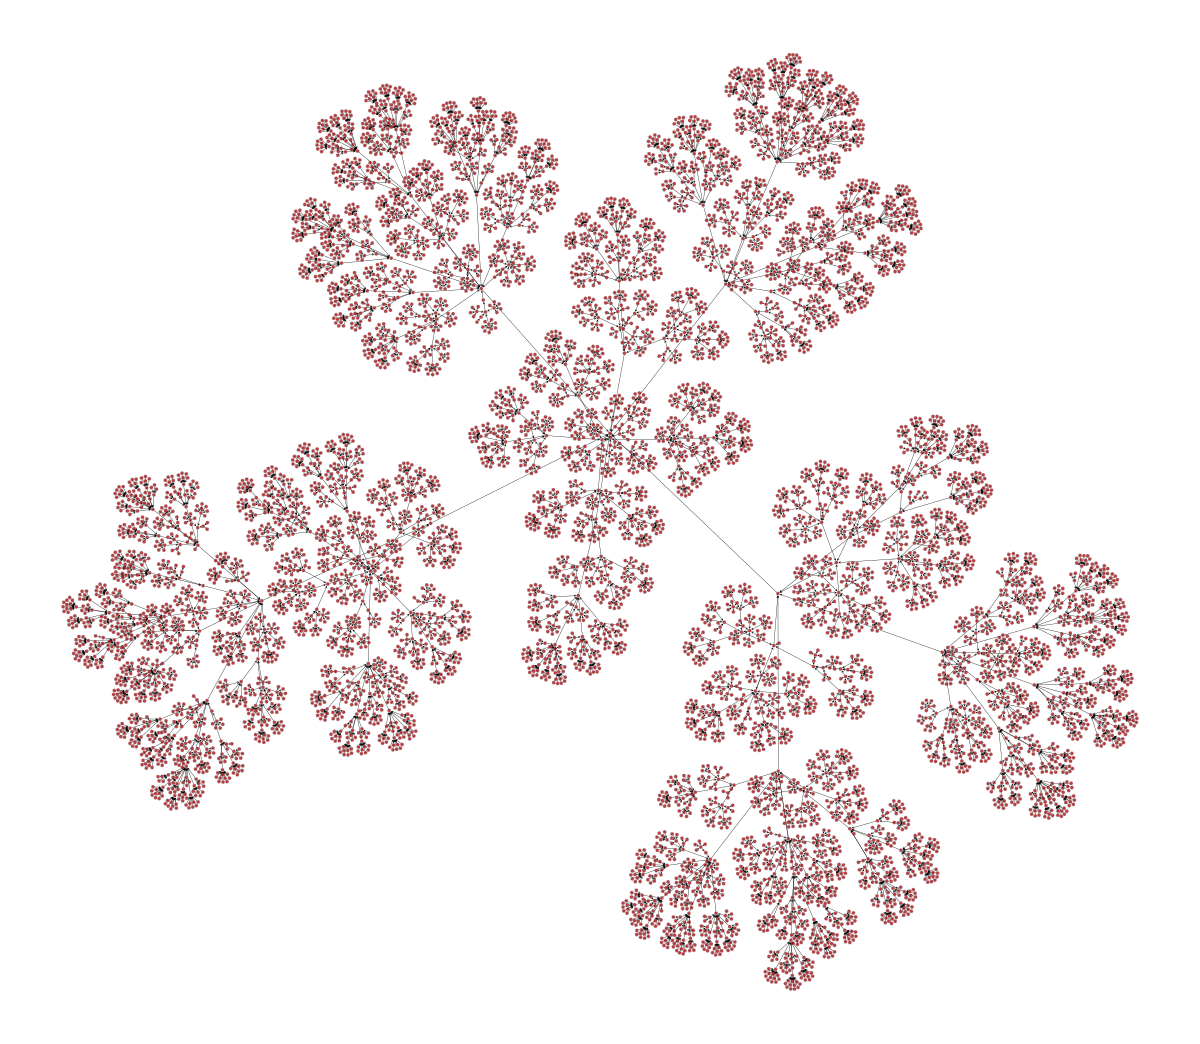

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x155de7970, at 0x155f23c10>

In [67]:
gt.graph_draw(graph_10000edges, edge_color='black')

In [ ]:
%sql DROP TABLE IF EXISTS graph_10000edges_shortest_path, graph_10000edges_shortest_path_summary;
%time %sql SELECT madlib.graph_sssp('graph_10000edges_v', 'vertex', 'graph_10000edges_e', NULL, 0, 'graph_10000edges_shortest_path');

In [ ]:
df = %sql SELECT vertex,parent,weight FROM graph_10000edges_shortest_path ORDER BY weight
df.index = df.vertex
df.drop(columns='vertex')

In [73]:
%sql \dt

 * postgresql://dominovaldano@localhost:6000/graph
34 rows affected.


,Schema,Name,Type,Owner
0,pg_temp_1198,__madlib_temp_temp13156584_1601513546_28360466__,table,dominovaldano
1,pg_temp_1198,__madlib_temp_temp151243309_1601513600_1452350__,table,dominovaldano
2,pg_temp_1198,__madlib_temp_temp185966776_1601513587_52959241__,table,dominovaldano
3,public,df,table,dominovaldano
4,public,drivers,table,dominovaldano
5,public,drivers150,table,dominovaldano
6,public,edge,table,dominovaldano
7,public,edge_alt,table,dominovaldano
8,public,edge_gr,table,dominovaldano
9,public,graph_10000edges_e,table,dominovaldano


In [76]:
vertices = list(df.index)
parents = { v : p for v,p in zip(vertices,df['parent']) }
weights = { v : w for v,w in zip(vertices,df['weight']) }

In [77]:
def get_paths(vert, par):
    paths = {}
    for end in vert:
        v = end
        path = []
        while v != par[v]:
            path.append(v)
            v = par[v]
        path.append(v)
        path.reverse()
        paths[end] = path
    return paths

In [78]:
paths = get_paths(vertices, parents)
paths

{0: [0],
 789: [0, 789],
 1510: [0, 1510],
 1514: [0, 789, 1514],
 989: [0, 789, 989],
 646: [0, 646],
 517: [0, 789, 989, 517],
 1261: [0, 789, 1261],
 1900: [0, 1900],
 587: [0, 587],
 1879: [0, 789, 1879],
 369: [0, 369],
 427: [0, 646, 427],
 474: [0, 646, 474],
 1104: [0, 789, 1261, 1104],
 389: [0, 789, 1514, 389],
 1468: [0, 1900, 1468],
 1424: [0, 789, 1424],
 1485: [0, 1900, 1468, 1485],
 1419: [0, 369, 1419],
 1755: [0, 646, 474, 1755],
 242: [0, 1510, 242],
 767: [0, 789, 1261, 767],
 1317: [0, 646, 474, 1317],
 265: [0, 1510, 265],
 1883: [0, 789, 1424, 1883],
 592: [0, 789, 989, 592],
 615: [0, 646, 615],
 889: [0, 789, 989, 517, 889],
 666: [0, 1510, 242, 666],
 1407: [0, 789, 989, 1407],
 999: [0, 789, 1261, 767, 999],
 670: [0, 1900, 670],
 1309: [0, 789, 989, 517, 889, 1309],
 1183: [0, 789, 1183],
 325: [0, 1510, 265, 325],
 1177: [0, 789, 1514, 1177],
 1214: [0, 1510, 1214],
 1816: [0, 1510, 242, 666, 1816],
 481: [0, 789, 1424, 481],
 542: [0, 789, 1879, 542],
 1411

In [79]:
%sql DROP TABLE IF EXISTS graph_10000edges_path1616
%time %sql SELECT madlib.graph_sssp_get_path('graph_10000edges_shortest_path',1616,'graph_10000edges_path1616')
df = %sql SELECT * FROM graph_10000edges_path1616
path1616 = df.values[0][0]
path1616

 * postgresql://dominovaldano@localhost:6000/graph
Done.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
CPU times: user 5.25 ms, sys: 715 µs, total: 5.97 ms
Wall time: 3.9 s
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.


[0, 369, 1419, 1381, 1080, 800, 981, 830, 1719, 1616]

In [ ]:
## TODO:  draw graph again, but with shortest path highlighted

In [ ]:
gt.graph_draw(graph_10000edges, edge_color='black')

# 150 Small Rideshare Problems in Parallel

In [ ]:
%%sql
DROP TABLE IF EXISTS rideshare150_out, rideshare150_out_summary;
SELECT madlib.graph_sssp('rideshare_v', 'vertex', 'rideshare150_e', NULL, 0, 'rideshare150_out', 'driver');

In [ ]:
%sql SELECT * FROM rideshare150_out ORDER BY driver, weight

In [ ]:
%sql DROP TABLE IF EXISTS rideshare150_path3;
%time %sql SELECT madlib.graph_sssp_get_path('rideshare150_out',3,'rideshare150_path3');
%sql SELECT * FROM rideshare150_path3 ORDER BY driver;

In [ ]:
%%sql DROP TABLE IF EXISTS out_gr_path;
SELECT madlib.graph_sssp_get_path('out_gr',5,'out_gr_path');
SELECT * FROM out_gr_path ORDER BY grp;

# Table creation

In [8]:
%%sql DROP TABLE IF EXISTS rideshare_v;
CREATE TABLE rideshare_v AS SELECT generate_series(0,4) AS vertex;

 * postgresql://dominovaldano@localhost:6000/graph
Done.
5 rows affected.


""


In [8]:
edge_tbl = { 'src' :    [0, 0, 1, 2, 1, 2, 1, 2, 4],
             'dest' :   [1, 2, 3, 3, 2, 1, 4, 4, 3],
             'weight' : [4.0, 2.0, 2.0, 4.0, 3.0, 1.0, 3.0, 5.0, 1.0]
           }

In [9]:
rideshare_e = pandas.DataFrame(edge_tbl)

In [10]:
rideshare_e

,src,dest,weight
0,0,1,4.0
1,0,2,2.0
2,1,3,2.0
3,2,3,4.0
4,1,2,3.0
5,2,1,1.0
6,1,4,3.0
7,2,4,5.0
8,4,3,1.0


In [11]:
%sql \d rideshare_e

 * postgresql://dominovaldano@localhost:6000/graph
3 rows affected.


,Column,Type,Modifiers
0,src,bigint,
1,dest,bigint,
2,weight,double precision,


In [12]:
%sql DROP TABLE IF EXISTS rideshare_e

 * postgresql://dominovaldano@localhost:6000/graph
Done.


""


In [13]:
%sql -p rideshare_e

 * postgresql://dominovaldano@localhost:6000/graph


'Persisted rideshare_e'

In [14]:
%sql ALTER TABLE rideshare_e DROP COLUMN index

 * postgresql://dominovaldano@localhost:6000/graph
Done.


""


In [15]:
%sql SELECT * FROM rideshare_e ORDER BY src,dest

 * postgresql://dominovaldano@localhost:6000/graph
9 rows affected.


,src,dest,weight
0,0,1,4.0
1,0,2,2.0
2,1,2,3.0
3,1,3,2.0
4,1,4,3.0
5,2,1,1.0
6,2,3,4.0
7,2,4,5.0
8,4,3,1.0


In [16]:
%%sql DROP TABLE IF EXISTS drivers;
CREATE TABLE drivers (id SERIAL, name TEXT);
INSERT INTO drivers (name)
VALUES
('Fred'),
('Anne'),
('Dave'),
('Amil'),
('Orhan'),
('Ekta'),
('Janice'),
('Bob'),
('Alice'),
( 'Jose'),
( 'Chang'),
('Sean'),
('Zhung'),
('Ed'),
('Nancy'),
( 'Stacy'),
( 'Melanie'),
('Domi'),
('Peter'),
('Kate'),
('Ming'),
( 'Nune'),
( 'Luna'),
('Torvald'),
('Stevens'),
('Veronica'),
('Elise'),
( 'Todd'),
( 'Blake'),
('Sue');

 * postgresql://dominovaldano@localhost:6000/graph
Done.
Done.
30 rows affected.


""


In [17]:
%sql SELECT * FROM drivers ORDER BY ID;

 * postgresql://dominovaldano@localhost:6000/graph
30 rows affected.


,id,name
0,1,Fred
1,2,Anne
2,3,Dave
3,4,Amil
4,5,Orhan
5,6,Ekta
6,7,Janice
7,8,Bob
8,9,Alice
9,10,Jose


In [18]:
%%sql DROP TABLE IF EXISTS drivers150;
CREATE TABLE drivers150 (id SERIAL, name TEXT);

 * postgresql://dominovaldano@localhost:6000/graph
Done.
Done.


""


In [19]:
%%sql ALTER SEQUENCE drivers150_id_seq MINVALUE 0 RESTART WITH 0;
INSERT INTO drivers150 (name) SELECT name || '_J' AS name FROM drivers;
INSERT INTO drivers150 (name) SELECT name || '_P' AS name FROM drivers;
INSERT INTO drivers150 (name) SELECT name || '_A' AS name FROM drivers;
INSERT INTO drivers150 (name) SELECT name || '_N' AS name FROM drivers;
INSERT INTO drivers150 (name) SELECT name || '_M' AS name FROM drivers;

 * postgresql://dominovaldano@localhost:6000/graph
Done.
30 rows affected.
30 rows affected.
30 rows affected.
30 rows affected.
30 rows affected.


""


In [20]:
%sql SELECT * FROM drivers150 ORDER BY id LIMIT 50;

 * postgresql://dominovaldano@localhost:6000/graph
50 rows affected.


,id,name
0,0,Orhan_J
1,1,Ekta_J
2,2,Alice_J
3,3,Jose_J
4,4,Chang_J
5,5,Zhung_J
6,6,Ed_J
7,7,Melanie_J
8,8,Ming_J
9,9,Stevens_J


In [21]:
%%sql DROP TABLE IF EXISTS rideshare150_e;
CREATE TABLE rideshare150_e AS SELECT * FROM drivers150, rideshare_e;

 * postgresql://dominovaldano@localhost:6000/graph
Done.
1350 rows affected.


""


In [22]:
%%sql DROP TABLE IF EXISTS rideshare150_e;
CREATE TABLE rideshare150_e AS SELECT id as driver_id, name AS driver, src, dest, weight FROM drivers150, rideshare_e;

 * postgresql://dominovaldano@localhost:6000/graph
Done.
1350 rows affected.


""


In [23]:
%sql SELECT * FROM rideshare150_e;

 * postgresql://dominovaldano@localhost:6000/graph
1350 rows affected.


,driver_id,driver,src,dest,weight
0,2,Alice_J,1,3,2.0
1,7,Melanie_J,1,3,2.0
2,19,Dave_J,1,3,2.0
3,34,Kate_P,1,3,2.0
4,41,Chang_P,1,3,2.0
...,...,...,...,...,...
1345,97,Nancy_N,1,4,3.0
1346,126,Amil_M,1,4,3.0
1347,140,Sue_M,1,4,3.0
1348,142,Jose_M,1,4,3.0


In [24]:
import graph_tool.all as gt

In [25]:
def prob(a, b):
    if a == b:
        return 0.999
    else:
        return 0.001

In [26]:
graph_10000edges, bm = gt.random_graph(2000, lambda: poisson(10), directed=False,
                             model="blockmodel",
                        block_membership=lambda: randint(10),
                         edge_probs=prob)

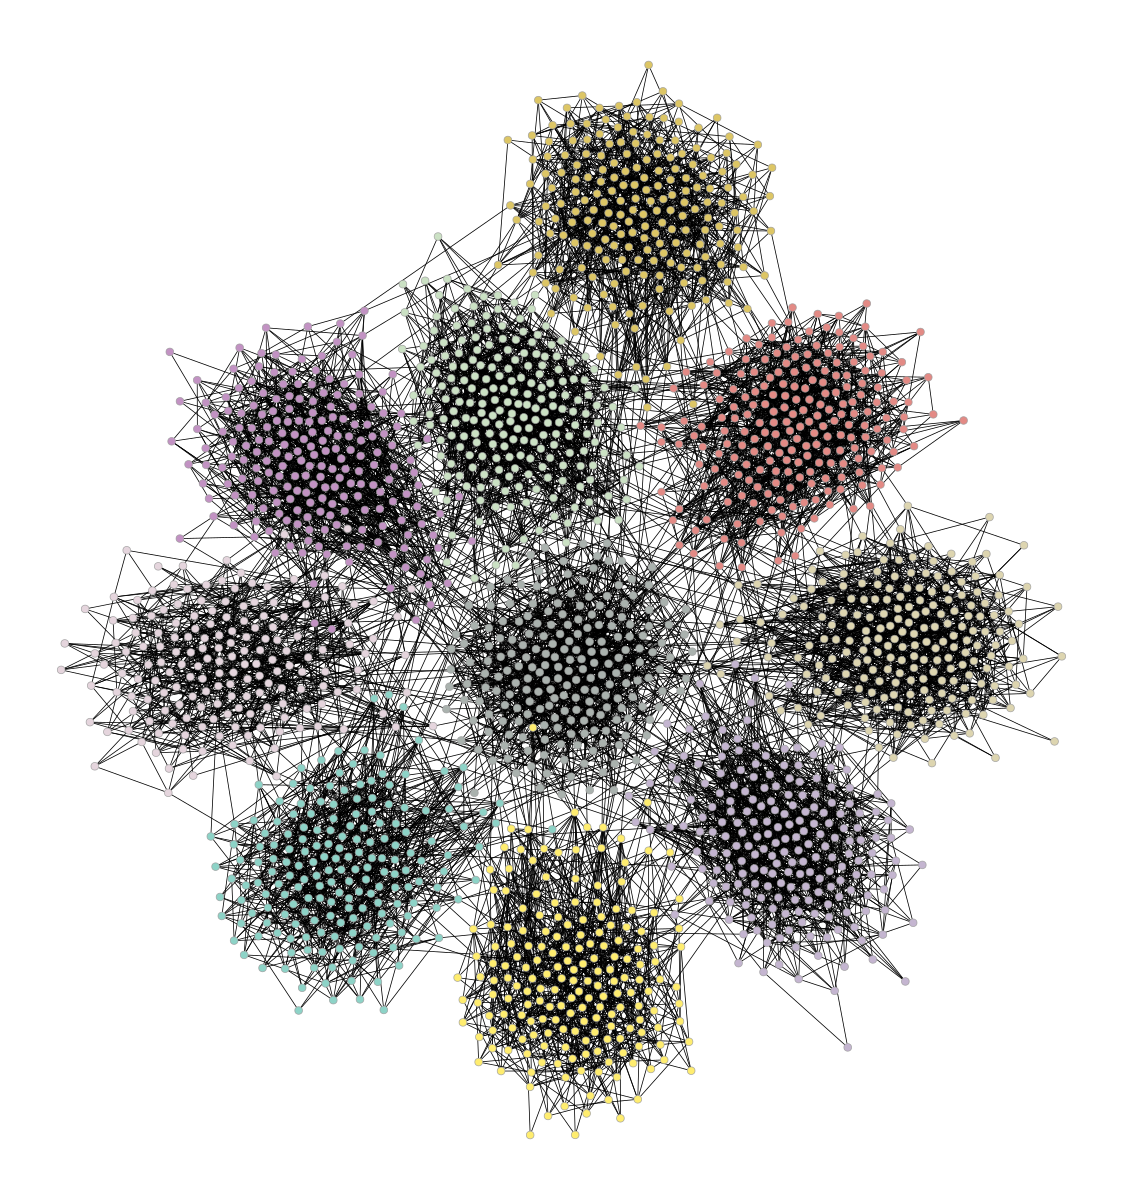

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1558f5910, at 0x1558880d0>

In [27]:
gt.graph_draw(graph_10000edges, vertex_fill_color=bm, edge_color="black")

In [28]:
verts = graph_10000edges.get_vertices()

In [29]:
edges = graph_10000edges.get_edges()

In [30]:
import random

In [31]:
len(edges)

9919

In [32]:
weights = [ random.randint(1,10) for _ in range(len(edges)) ]

In [33]:
def create_vertex_tbl(tbl, num_verts):
    %sql DROP TABLE IF EXISTS {tbl}
    %sql CREATE TABLE {tbl} AS SELECT generate_series(0,{num_verts}-1) AS vertex DISTRIBUTED BY (vertex)

In [34]:
create_vertex_tbl('graph_10000edges_v', 2000)

 * postgresql://dominovaldano@localhost:6000/graph
Done.
 * postgresql://dominovaldano@localhost:6000/graph
2000 rows affected.


In [35]:
%sql SELECT * FROM graph_10000edges_v ORDER BY vertex

 * postgresql://dominovaldano@localhost:6000/graph
2000 rows affected.


,vertex
0,0
1,1
2,2
3,3
4,4
...,...
1995,1995
1996,1996
1997,1997
1998,1998


In [36]:
def create_edge_tbl(tbl, edges):
    
    rows = [ list(edge) + [weight] for edge,weight in zip(edges,weights) ]
    %sql CREATE TABLE {tbl} (id SERIAL, src INTEGER, dest INTEGER, weight INTEGER) DISTRIBUTED BY (id)
    for row in rows:
        source, destination, weight = row
        %sql INSERT INTO {tbl} (src, dest, weight) SELECT {source} AS src, {destination} AS dest, {weight} AS weight

In [38]:
%sql DROP TABLE IF EXISTS graph_10000edges_e

 * postgresql://dominovaldano@localhost:6000/graph
Done.


""


In [39]:
create_edge_tbl('graph_10000edges_e', edges)

 * postgresql://dominovaldano@localhost:6000/graph
Done.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows affected.
 * postgresql://dominovaldano@localhost:6000/graph
1 rows a

In [40]:
%sql SELECT * FROM graph_10000edges_v

 * postgresql://dominovaldano@localhost:6000/graph
2000 rows affected.


,vertex
0,2
1,3
2,4
3,7
4,8
...,...
1995,1991
1996,1993
1997,1994
1998,1996


In [41]:
%sql SELECT * FROM graph_10000edges_e ORDER by id

 * postgresql://dominovaldano@localhost:6000/graph
9919 rows affected.


,id,src,dest,weight
0,1,0,1900,7
1,2,0,389,10
2,3,0,789,2
3,4,0,646,6
4,5,0,1510,5
...,...,...,...,...
9914,9915,1999,1797,8
9915,9916,1999,1053,9
9916,9917,1999,260,5
9917,9918,1999,212,7


# Example from Docs

In [ ]:
%%sql DROP TABLE IF EXISTS vertex, edge;
CREATE TABLE vertex(
        id INTEGER
        );
CREATE TABLE edge(
        src INTEGER,
        dest INTEGER,
        weight FLOAT8
        );
INSERT INTO vertex VALUES
(0),
(1),
(2),
(3),
(4),
(5),
(6),
(7);
INSERT INTO edge VALUES
(0, 1, 1.0),
(0, 2, 1.0),
(0, 4, 10.0),
(1, 2, 2.0),
(1, 3, 10.0),
(2, 3, 1.0),
(2, 5, 1.0),
(2, 6, 3.0),
(3, 0, 1.0),
(4, 0, -2.0),
(5, 6, 1.0),
(6, 7, 1.0);

In [ ]:
%%sql 
DROP TABLE IF EXISTS out, out_summary;
SELECT madlib.graph_sssp(
                         'vertex',      -- Vertex table
                         NULL,          -- Vertix id column (NULL means use default naming)
                         'edge',        -- Edge table
                         NULL,          -- Edge arguments (NULL means use default naming)
                         0,             -- Source vertex for path calculation
                         'out');        -- Output table of shortest paths
SELECT * FROM out ORDER BY id;

In [ ]:
%%sql DROP TABLE IF EXISTS out_path;
SELECT madlib.graph_sssp_get_path('out',5,'out_path');
SELECT * FROM out_path;

In [ ]:
%%sql DROP TABLE IF EXISTS vertex_alt, edge_alt;
CREATE TABLE vertex_alt AS SELECT id AS v_id FROM vertex;
CREATE TABLE edge_alt AS SELECT src AS e_src, dest, weight AS e_weight FROM edge;

In [ ]:
%%sql DROP TABLE IF EXISTS out_alt, out_alt_summary;
SELECT madlib.graph_sssp(
                         'vertex_alt',                  -- Vertex table
                         'v_id',                        -- Vertex id column (NULL means use default naming)
                         'edge_alt',                    -- Edge table
                         'src=e_src, weight=e_weight',  -- Edge arguments (NULL means use default naming)
                         1,                             -- Source vertex for path calculation
                         'out_alt');                    -- Output table of shortest paths
SELECT * FROM out_alt ORDER BY v_id;


In [ ]:
%%sql DROP TABLE IF EXISTS edge_gr;
CREATE TABLE edge_gr AS
(
  SELECT *, 0 AS grp FROM edge
  UNION
  SELECT *, 1 AS grp FROM edge WHERE src < 6 AND dest < 6
);
INSERT INTO edge_gr VALUES
(4,5,-20,1);

In [ ]:
%sql SELECT * from vertex;

In [ ]:
%sql SELECT * from edge_gr

In [ ]:
%%sql DROP TABLE IF EXISTS out_gr, out_gr_summary;
SELECT madlib.graph_sssp(
                         'vertex',      -- Vertex table
                         NULL,          -- Vertex id column (NULL means use default naming)
                         'edge_gr',     -- Edge table
                         NULL,          -- Edge arguments (NULL means use default naming)
                         0,             -- Source vertex for path calculation
                         'out_gr',      -- Output table of shortest paths
                         'grp'          -- Grouping columns
);
SELECT * FROM out_gr ORDER BY grp,id;